In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [4]:
train = pd.read_csv('C:/Users/s_csmscox/jupyterSave/fashion-mnist_train.csv')
test = pd.read_csv('C:/Users/s_csmscox/jupyterSave/fashion-mnist_test.csv')

train_label = train['label']
train.drop(['label'], axis=1, inplace=True)

test_label = test['label']
test.drop(['label'], axis=1, inplace=True)

### 정규화
scaler_train = MinMaxScaler()
scaler_train.fit(train)
norm_train_x = scaler_train.transform(train)

scaler_test = MinMaxScaler()
scaler_test.fit(train)
norm_test_x = scaler_test.transform(test)

### tensorflow 기능을 이용해서 one hot encoding을 생성
sess = tf.Session()
onehot_train_label = sess.run(tf.one_hot(train_label, depth=10))

In [12]:
# placeholder
X = tf.placeholder(shape=[None,784], dtype=tf.float32)
T = tf.placeholder(shape=[None,10], dtype=tf.float32)

# Weight & bias
W = tf.Variable(tf.random.normal([784,10]), name='weight')
b = tf.Variable(tf.random.normal([10]), name='bias')

# Hypothesis
logit = tf.matmul(X,W) + b
H = tf.nn.softmax(logit)  # softmax activation function

# loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logit,
                                                                 labels=T))
# train
train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(loss)

# parameter
num_of_epoch = 2000
batch_size = 10000

# 학습용 함수
def run_train(sess,train_x, train_t):
    print('### 학습 시작 ###')
    # 초기화
    sess.run(tf.global_variables_initializer())
    
    for step in range(num_of_epoch):
        total_batch = int(train_x.shape[0] / batch_size)
        
        for i in range(total_batch):
            batch_x = train_x[i*batch_size:(i+1)*batch_size]
            batch_t = train_t[i*batch_size:(i+1)*batch_size]           
            _, loss_val = sess.run([train,loss],
                                   feed_dict={X: batch_x, T: batch_t})
            
        if step % 100 == 0:
            print('Loss : {}'.format(loss_val))
    print('### 학습 종료 ###')


In [13]:
# Accuracy    
predict = tf.argmax(H,1)
correct = tf.equal(predict, tf.argmax(T,1))
accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))

# K-Fold Cross Validation
cv = 5          # Fold의 수
results = []    
                
kf = KFold(n_splits=cv, shuffle=True) 

for training_idx, validation_idx in kf.split(norm_train_x):
    training_x = norm_train_x[training_idx] # Fancy indexing
    training_t = onehot_train_label[training_idx]
    
    val_x = norm_train_x[validation_idx]
    val_t = onehot_train_label[validation_idx]
    
    run_train(sess,training_x,training_t)
    acc = sess.run(accuracy, feed_dict={X:val_x, T:val_t})
    print('측정한 각각의 결과값 : {}'.format(acc))
    results.append(acc)


print('최종 K-Fold 교차검증을 사용한 Accuracy : {}'.format(np.mean(results)))

### 학습 시작 ###
Loss : 12.563332557678223
Loss : 1.7948132753372192
Loss : 1.411192536354065
Loss : 1.236683964729309
Loss : 1.129176378250122
Loss : 1.0531063079833984
Loss : 0.994915246963501
Loss : 0.9481379985809326
Loss : 0.9092431664466858
Loss : 0.8761132955551147
Loss : 0.8473778367042542
Loss : 0.8220950961112976
Loss : 0.7995910048484802
Loss : 0.7793689966201782
Loss : 0.7610540986061096
Loss : 0.7443560361862183
Loss : 0.7290467023849487
Loss : 0.7149415016174316
Loss : 0.7018910050392151
Loss : 0.6897708177566528
### 학습 종료 ###
측정한 각각의 결과값 : 0.8063333630561829
### 학습 시작 ###
Loss : 14.670181274414062
Loss : 1.7868245840072632
Loss : 1.4194927215576172
Loss : 1.2500920295715332
Loss : 1.1421419382095337
Loss : 1.064643383026123
Loss : 1.0049124956130981
Loss : 0.9567506909370422
Loss : 0.9167492985725403
Loss : 0.8827683329582214
Loss : 0.8533787131309509
Loss : 0.8275905251502991
Loss : 0.8046970963478088
Loss : 0.7841760516166687
Loss : 0.7656320333480835
Loss : 0.74875885248

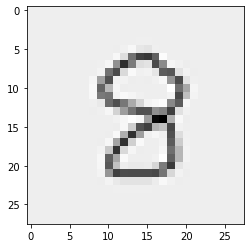

예측 값 : 7


In [14]:
# 공식을 이용해서 직접 img를 흑백처리

from PIL import Image
import matplotlib.pyplot as plt

img = np.asarray(Image.open('C:/Users/s_csmscox/jupyterSave/8.png'))

# 그레이 스케일링
r = 0.2989
g = 0.5870
b = 0.1140
gray = img[:, :, 0] * r + img[:, :, 1] * g + img[:, :, 2] * b
img = Image.fromarray(gray)

# 사이즈 조절
img = img.resize((28,28))

# 예측
img = np.asarray(img)
plt.imshow(img, cmap='gray') # cmap='gray_r의 경우 흑백 반전 = Greys'
plt.show()

img = 255 - img
norm_img = scaler_test.transform(img.reshape(1,-1))

result = sess.run(H, feed_dict={X: norm_img})

for i in result:
    m = i.max()
    for j in range(10):
        if i[j] == m:
            print("예측 값 : {}".format(j))
            break

In [16]:
result = sess.run(H, feed_dict={X: norm_test_x})
pred = []

for i in result:
    m = i.max()
    for j in range(10):
        if i[j] == m:
            pred.append(j)
            break

cnt = 0
for predict, answer in zip(pred, test_label):
    if predict == answer:
        cnt += 1

print("Accuracy : {}".format((cnt/len(pred))))

Accuracy : 0.8082
